In [1]:
# import os
# os.environ['USE_PYGEOS']
import geopandas as gpd
from pathlib import Path
import warnings

import networkx as nx
import geonetworkx as gnx

warnings.filterwarnings("ignore")

/tmp/ipykernel_25086/2199634864.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [4]:
from reservoirnetwork.reservoir_component import StreamflowRegulation

In [94]:
river_network_fn = Path('../../data/gunnison_rivreg/gunnison_rivreg.geojson')
river_network_pts_fn = Path('../../data/gunnison_rivreg/gunnison_rivreg_pts.geojson')

# river_network = gpd.read_file(river_network_fn)
# river_network.to_xarray()

river_network_pts = gpd.read_file(river_network_pts_fn)
river_network_pts.to_xarray()

<xarray.Dataset>
Dimensions:    (index: 18)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Data variables:
    x          (index) object '-106.604289' '-107.333611' ... '-106.9533773'
    y          (index) object '38.820602' '38.45367' ... '38.85165929'
    name       (index) object 'Taylor_Park' 'Blue_Mesa' ... 'GUN03' 'SLA00'
    id         (index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
    elevation  (index) float64 2.879e+03 2.322e+03 ... 2.315e+03 2.698e+03
    geometry   (index) object POINT (-106.604289 38.820602) ... POINT (-106.9...

{0: Text(-0.828571428571, -0.365079365079, '0'),
 1: Text(0.428571428571, 0.0920634920635, '1'),
 2: Text(0.0285714285714, 0.149206349206, '2'),
 3: Text(-0.428571428571, 0.0349206349206, '3'),
 4: Text(-0.771428571429, -0.307936507937, '4'),
 5: Text(1.0, -0.365079365079, '5'),
 6: Text(-0.714285714286, -0.250793650794, '6'),
 7: Text(0.714285714286, -0.193650793651, '7'),
 8: Text(-0.542857142857, -0.0793650793651, '8'),
 9: Text(-0.485714285714, -0.0222222222222, '9'),
 10: Text(0.0857142857143, 0.206349206349, '10'),
 11: Text(0.2, 0.320634920635, '11'),
 12: Text(0.257142857143, 0.263492063492, '12'),
 13: Text(-0.2, 0.263492063492, '13'),
 14: Text(-0.0285714285714, 0.206349206349, '14'),
 15: Text(-0.142857142857, 0.320634920635, '15'),
 16: Text(0.657142857143, -0.136507936508, '16'),
 17: Text(0.771428571429, -0.136507936508, '17')}

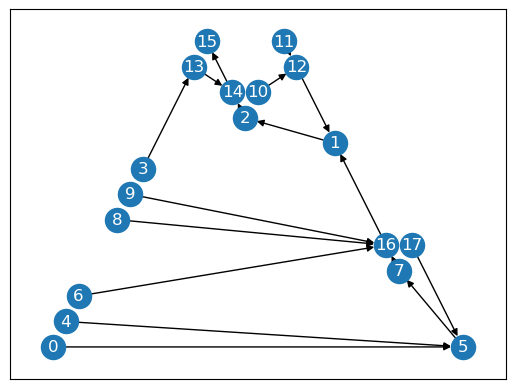

In [95]:
# quick and simple implementation without landlab

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
# nx.draw(G, nx.drawing.planar_layout(G))
nx.draw_networkx_nodes(G, nx.drawing.planar_layout(G))
nx.draw_networkx_edges(G, nx.drawing.planar_layout(G))
nx.draw_networkx_labels(G, nx.drawing.planar_layout(G), font_color='white')

In [96]:
list(nx.topological_sort(G)) # upstream most is first element

[0, 3, 4, 6, 8, 9, 10, 11, 17, 13, 12, 5, 7, 16, 1, 2, 14, 15]

Method:

- Generate topologically sorted list of nodes. This will provide a sequence of nodes with the downstream most node at the end.
- For each Node:
    - Obtain `natural_inflow` from RAT routing results.
    - Obtain `storage_change`. In-situ (for now, later replace with satellite estimates). This will be 0 if node is USGS gage.
    - Get list of upstream nodes.
    - If any upstream nodes, for each upstream node:
        - Obtain **routed** `natural_inflow`.  ; routed = time-lagged
        - Obtain **routed** `outflow`.
    - Calculate `regulated_inflow` = `natural_inflow - sum(upstream_reservoirs['natural_inflow']) + sum(upstream_reservoirs['outflow'])`
    - Calculate `outflow` = `regulated_inflow - `

In [106]:
import xarray as xr
import pandas as pd

In [109]:
regulation_data_fn = Path("../../data/regulation/regulation.nc")
regulation_data_fn.parent.mkdir(exist_ok=True)

if regulation_data_fn.exists():
    regulation_data = xr.open_dataset(regulation_data_fn)

regulation_data = xr.Dataset()
regulation_data

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [137]:
# read natural_inflows of nodes/stations and store in `regulation_data`
natural_inflow_dir = Path("../../data/colorado/basins/gunnison/ro/rout_inflow")
storage_change_dir = Path("../../data/colorado/basins/gunnison/final_outputs/dels")

# for node in G:
i = 0
node = G.nodes[i]
name = node['name']

# natural inflow
natural_inflow_fn = natural_inflow_dir / f"{name[:5]: <5}.csv"
natural_inflow = pd.read_csv(natural_inflow_fn, parse_dates=['date']).rename({
    'date': 'time',
    'streamflow': 'natural_inflow'
    }, axis='columns')
natural_inflow['node'] = i
natural_inflow.set_index(['time', 'node'], inplace=True)
natural_inflow = natural_inflow.to_xarray()

# storage change
storage_change

<xarray.Dataset>
Dimensions:         (time: 2292, node: 1)
Coordinates:
  * time            (time) datetime64[ns] 2016-10-23 2016-10-24 ... 2023-01-31
  * node            (node) int64 0
Data variables:
    natural_inflow  (time, node) float64 0.008433 0.288 2.477 ... 0.1239 0.1247

# Convert data into landlab grid

In [26]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import geopandas as gpd

from landlab import NetworkModelGrid

from landlab.io.shapefile import read_shapefile

In [27]:
nmg = read_shapefile(
    file = river_network_fn,
    dbf = river_network_fn.with_suffix('.dbf'),
    points_shapefile = river_network_pts_fn,
    points_dbf = river_network_pts_fn.with_suffix('.dbf'),
    threshold = 1e-6
)
nmg.ds

<xarray.Dataset>
Dimensions:        (node: 18, link: 17, Two: 2)
Coordinates:
  * node           (node) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Dimensions without coordinates: link, Two
Data variables:
    mesh           <U1 'a'
    y_of_node      (node) float64 37.98 38.03 38.23 38.26 ... 38.78 38.82 38.85
    x_of_node      (node) float64 -107.3 -107.3 -107.5 ... -106.9 -106.6 -107.0
    nodes_at_link  (link, Two) int64 0 4 1 4 2 3 3 8 ... 12 13 13 15 13 16 13 17

In [28]:
nmg.at_link.keys()

['v', 'u', 'x_of_polyline', 'slope', 'length', 'y_of_polyline']

In [30]:
nmg.at_node.keys()

['elevation', 'y', 'x', 'id']

<AxesSubplot:xlabel='x', ylabel='y'>

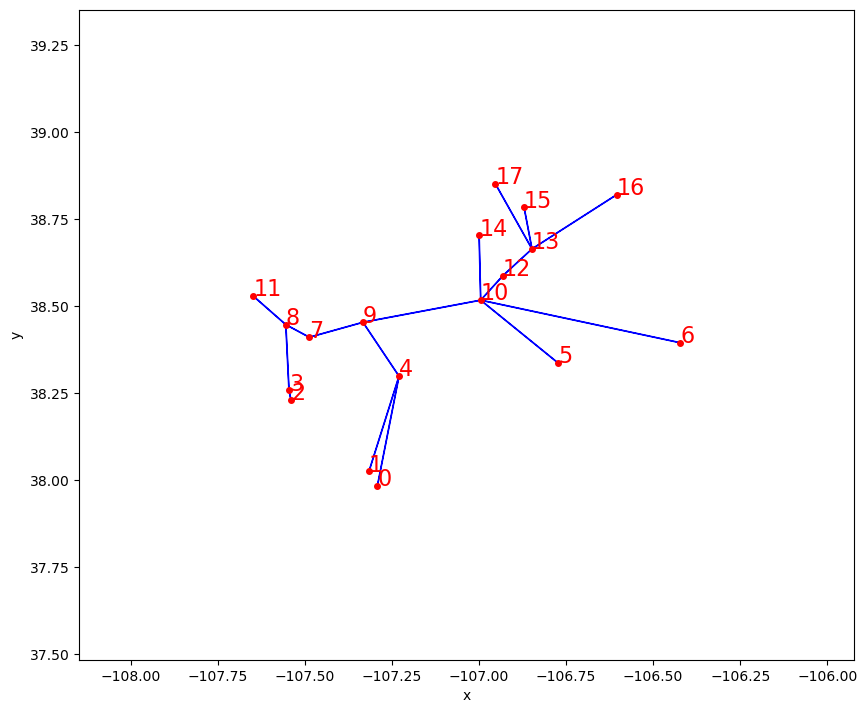

In [46]:
from landlab.plot.graph import plot_graph, plot_links
import matplotlib.pyplot as plt 

f, ax = plt.subplots(figsize=(10, 10))

plot_links(nmg, as_arrow=False, with_id=False) # looks like the link directions are messed up...
plot_graph(nmg, "node", with_id=True, axes=ax)

In [ ]:
# Quick and simple implementation without using landlab
